In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from datetime import timedelta
from dateutil.relativedelta import relativedelta


In [2]:
plt.style.use('Solarize_Light2')

## Loading and Formatting Data

In [253]:
#read in rhpi data

rhpi = pd.read_csv('rhpi.csv',encoding="utf-16",sep='\t')

#subset data for los angeles

la_rhpi = rhpi[rhpi['Region Name'] == "Los Angeles, CA"][['Month, Year of Date','Redfin HPI MoM']]

#convert types, rename, and sort index
la_rhpi['Month, Year of Date'] = pd.to_datetime(la_rhpi['Month, Year of Date'])
la_rhpi.rename(columns={'Month, Year of Date':'Date'},inplace=True)
la_rhpi.sort_values('Date',inplace=True)
la_rhpi.set_index('Date',inplace=True)

#fix formatting
la_rhpi['Redfin HPI MoM'] = la_rhpi['Redfin HPI MoM'].apply(lambda x:float(str(x).replace('%','')))

#make time series just the RHPI month over month
la_rhpi = la_rhpi['Redfin HPI MoM']

la_rhpi.dropna(inplace=True)

In [248]:
#import housing related information by city

info = pd.read_csv('city_market_tracker.tsv000',sep='\t')

#take subset for los angeles and take mean of variables across different periods and cities to get one mean per period for LA
la_info = info[(info['parent_metro_region'] == 'Los Angeles, CA') & (info['property_type'] == 'Single Family Residential')]
features = la_info.groupby(['period_begin']).mean()[['median_sale_price_mom','median_list_price_mom','median_ppsf_mom','median_list_ppsf_mom','homes_sold_mom','new_listings_mom','inventory_mom','sold_above_list_mom','price_drops_mom','median_dom_mom','months_of_supply_mom','avg_sale_to_list_mom']]

#make index datetime type and set date to match rhpi
features.index = pd.to_datetime(features.index)
features = features[(features.index >= '2012-04-01') & (features.index <= '2024-05-01')]

In [239]:
mortgage = pd.read_csv('MORTGAGE30US.csv')

#set date in datetime format as index
mortgage['DATE'] = pd.to_datetime(mortgage['DATE'])
mortgage.set_index('DATE', inplace=True)

#fill missing values that are '.' values with previous value
mortgage = mortgage.replace('.',pd.NA).ffill()

mortgage['MORTGAGE30US'] = mortgage['MORTGAGE30US'].apply(lambda x:float(x))

#convert weekly data to monthly data and make every datetime the beginning of the month
mortgage = mortgage.resample('M').mean()
mortgage.index = mortgage.index.to_period('M').to_timestamp('D')

#select dates to match rhpi data
mortgage = mortgage[(mortgage.index >= '2012-04-01') & (mortgage.index <= '2024-05-01')]

mortgage = mortgage['MORTGAGE30US']

In [240]:
#read in unemployment data

unemp = pd.read_csv('la_unemployment.csv')

#create datetime index and set it as index
unemp['Date'] = pd.to_datetime(unemp['Year'].astype(str) + ' ' + unemp['Period'] + ' 1', format='%Y %b %d')
unemp = unemp[['Date','unemployment rate']]
unemp.set_index('Date',inplace=True)

#subset series to match la rhpi data
unemp = unemp[(unemp.index >= '2012-04-01') & (unemp.index <= '2024-05-01')]
unemp = unemp['unemployment rate']

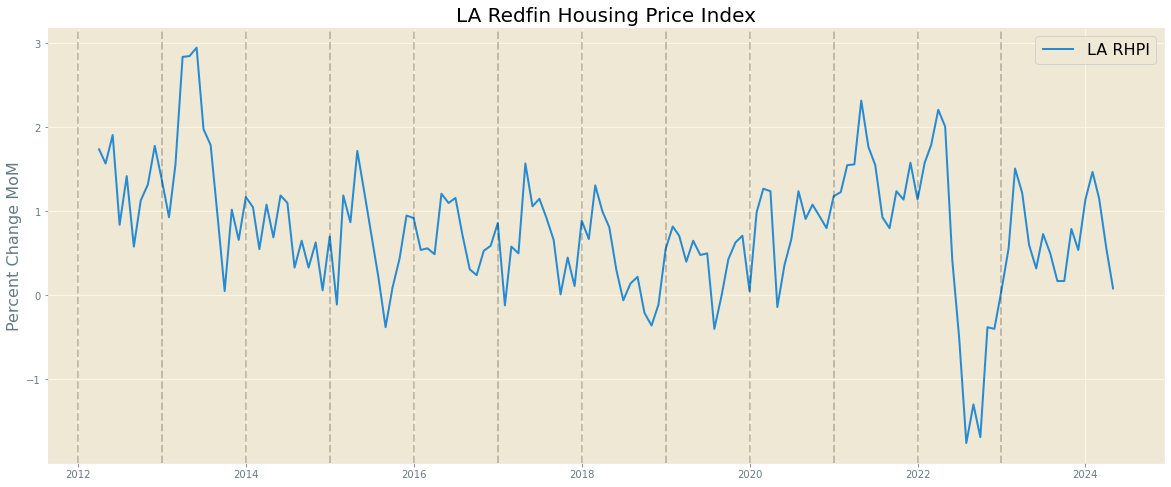

In [217]:
#plot Los Angeles Redfin Housing Price Index

plt.figure(figsize=(20,8))
plt.plot(la_rhpi)
plt.title('LA Redfin Housing Price Index', fontsize=20)
plt.ylabel('Percent Change MoM', fontsize=16)
plt.legend(['LA RHPI'], fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

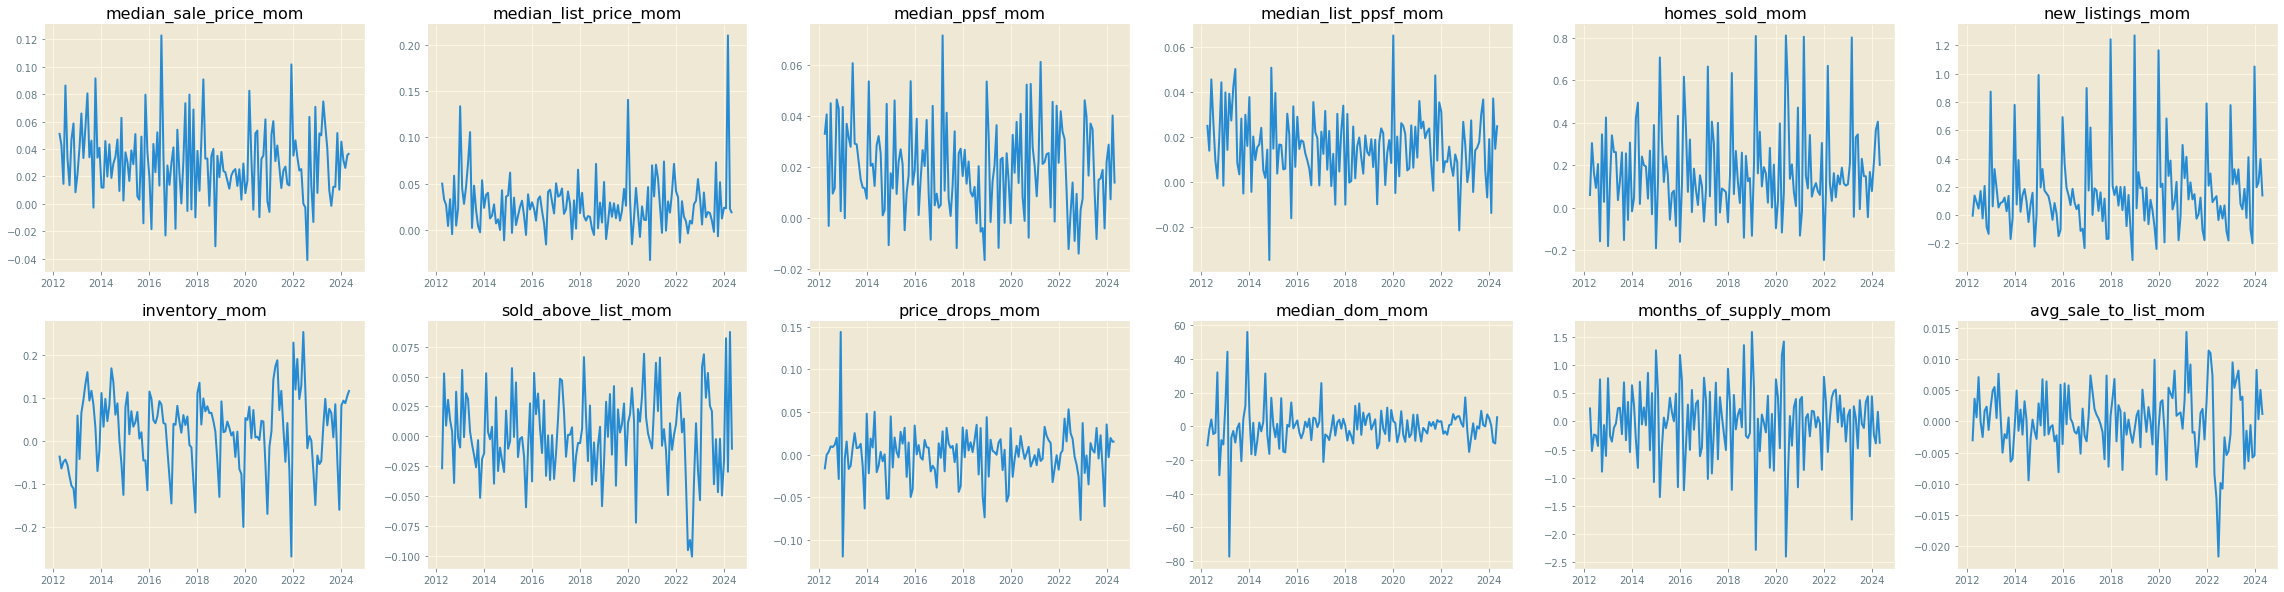

In [218]:
fig, axes = plt.subplots(2, 6, figsize=(40, 10))
axes = axes.flatten()
for i in range(12):
    axes[i].plot(features[features.columns[i]])
    axes[i].set_title(f'{features.columns[i]}')


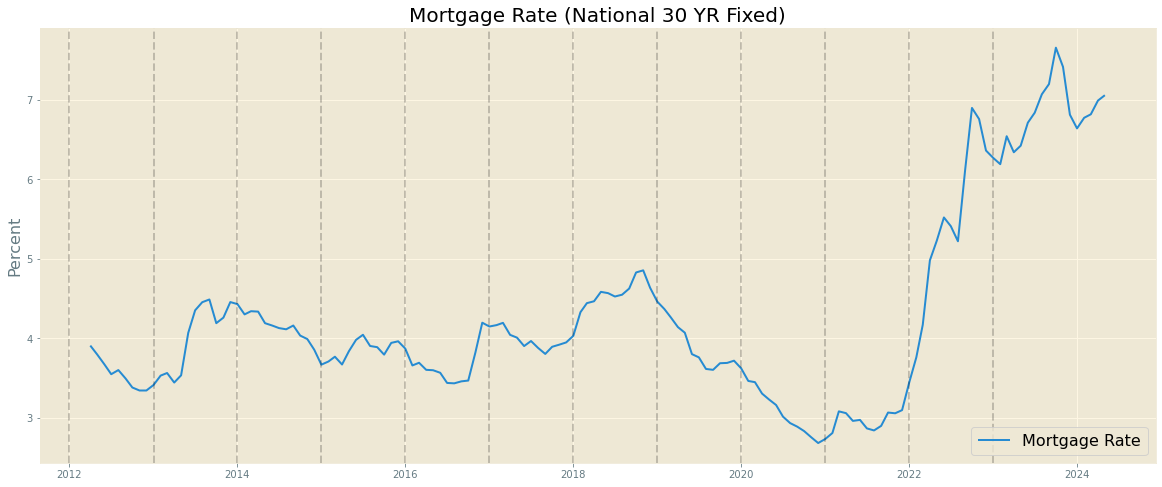

In [219]:
#plot national mortgage rates

plt.figure(figsize=(20,8))
plt.plot(mortgage)
plt.title('Mortgage Rate (National 30 YR Fixed)', fontsize=20)
plt.ylabel('Percent', fontsize=16)
plt.legend(['Mortgage Rate'], fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

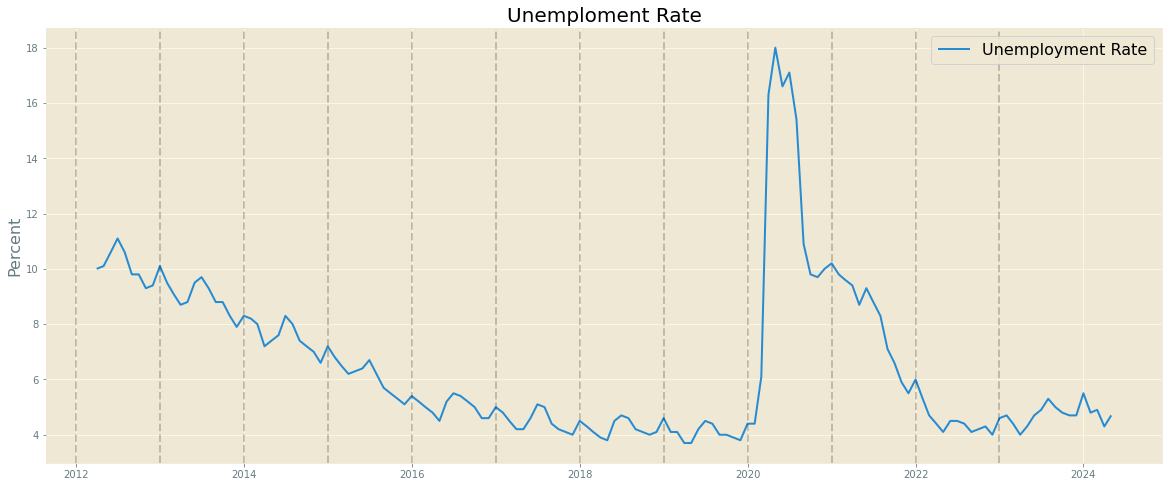

In [220]:
#plot national mortgage rates

plt.figure(figsize=(20,8))
plt.plot(unemp)
plt.title('Unemploment Rate', fontsize=20)
plt.ylabel('Percent', fontsize=16)
plt.legend(['Unemployment Rate'], fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Cross Correlation Analysis

In [171]:
def cross_correlation_with_lags(ts1, ts2, max_lag):
    correlations = {}
    
    for lag in range(1, max_lag):
        # shift ts2 by 'lag' positions
        shifted_ts2 = ts2.shift(lag)
        
        # calculate correlation
        correlation = ts1.corr(shifted_ts2)
        correlations[lag] = correlation
    
    return correlations

In [172]:
for feature in features.columns:
    corrs = cross_correlation_with_lags(la_rhpi,features[feature],6)
    abs_max_index = np.argmax(np.abs(list(corrs.values())))
    
    if(list(corrs.values())[abs_max_index] > 0.3):
        print(feature)
        print(f'Cross Corr of {list(corrs.keys())[abs_max_index]}:{list(corrs.values())[abs_max_index]}')
        print('------------')

median_list_price_mom
Cross Corr of 3:0.3863361638649567
------------
median_ppsf_mom
Cross Corr of 1:0.37573041407307983
------------
median_list_ppsf_mom
Cross Corr of 3:0.3331883171220662
------------
sold_above_list_mom
Cross Corr of 1:0.4373248721394564
------------
avg_sale_to_list_mom
Cross Corr of 1:0.500738591629138
------------


In [241]:
important_features = ['median_sale_price_mom','median_ppsf_mom','median_list_ppsf_mom','sold_above_list_mom','avg_sale_to_list_mom']

## Cleaning Time Series

Here we have a total of 6 time series to clean - the LA RHPI, as well as the five feature series we identified above through the cross correlation analysis. 

In [242]:
def normalize_series(series):

    mean, std = series.mean(),series.std()
    series = (series - mean)/std

    return series

### LA RHPI

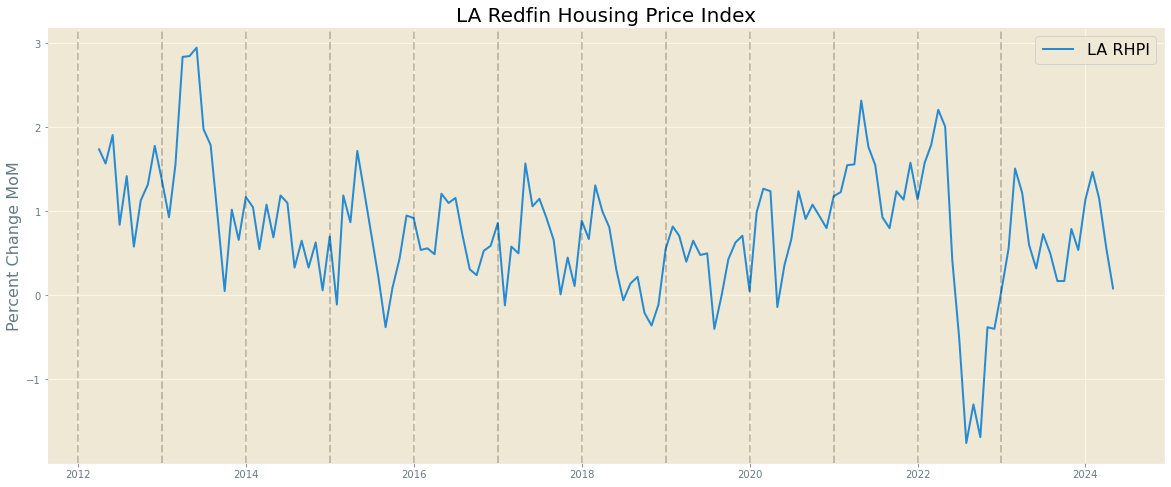

In [254]:
#plot Los Angeles Redfin Housing Price Index

plt.figure(figsize=(20,8))
plt.plot(la_rhpi)
plt.title('LA Redfin Housing Price Index', fontsize=20)
plt.ylabel('Percent Change MoM', fontsize=16)
plt.legend(['LA RHPI'], fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [255]:
#normalize
la_rhpi = normalize_series(la_rhpi)

In [245]:
# #remove trend with first difference
# la_rhpi = la_rhpi.diff().dropna()

In [256]:
#normalize MoM features

for feature in important_features:
    features[feature] = normalize_series(features[feature])

### Mortgage Rates

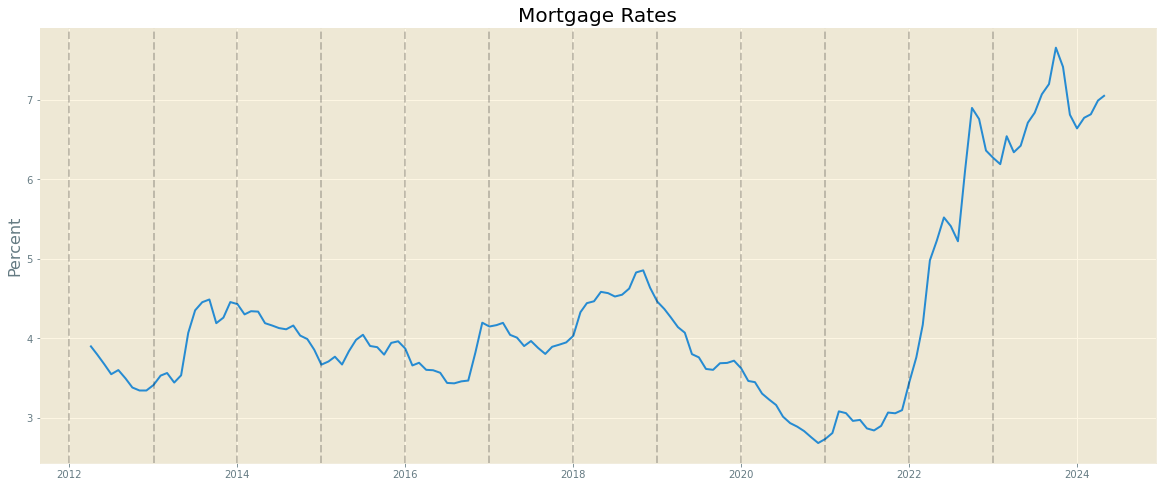

In [257]:
#plot mortgage rates

plt.figure(figsize=(20,8))
plt.plot(mortgage)
plt.title('Mortgage Rates', fontsize=20)
plt.ylabel('Percent', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [258]:
mortgage = normalize_series(mortgage)

In [260]:
#take first difference to remove trend

mortgage = mortgage.diff().dropna()

### Unemployment Rates

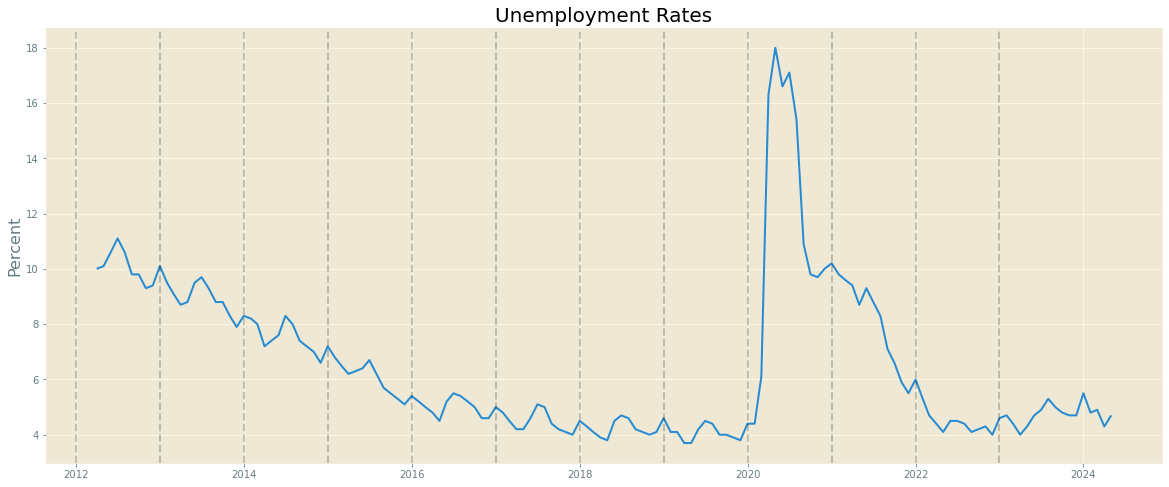

In [262]:
#plot unemployment rates

plt.figure(figsize=(20,8))
plt.plot(unemp)
plt.title('Unemployment Rates', fontsize=20)
plt.ylabel('Percent', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [263]:
unemp = normalize_series(unemp)

In [264]:
#take first difference to remove trend

unemp = unemp.diff().dropna()

## Tests for Stationarity

In [269]:
for feature in important_features:
    test_result = adfuller(features[feature])
    print(feature)
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])


median_sale_price_mom
ADF Statistic: -14.399663
p-value: 0.000000
median_ppsf_mom
ADF Statistic: -13.765746
p-value: 0.000000
median_list_ppsf_mom
ADF Statistic: -15.191731
p-value: 0.000000
sold_above_list_mom
ADF Statistic: -6.510477
p-value: 0.000000
avg_sale_to_list_mom
ADF Statistic: -6.462174
p-value: 0.000000


In [270]:
test_result = adfuller(la_rhpi)
print('LA RHPI')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

LA RHPI
ADF Statistic: -4.001712
p-value: 0.001402


In [271]:
test_result = adfuller(mortgage)
print('Mortgage Rate')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

Mortgage Rate
ADF Statistic: -3.959758
p-value: 0.001637


In [272]:
test_result = adfuller(unemp)
print('Unemployment Rate')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

Unemployment Rate
ADF Statistic: -6.884666
p-value: 0.000000


## Modeling

In [329]:
model_df = features[important_features].copy()
model_df['mortgage'] = mortgage
model_df['unemployemnt'] = unemp
model_df['la_rhpi'] = la_rhpi

#remove first column because of differencing
model_df = model_df[model_df.index > '2012-04-01']

model_df = model_df.asfreq('MS') 

In [331]:
train_cutoff= round(len(model_df) * 0.7)
val_cutoff= round(len(model_df) * 0.85)
test_cutoff= len(model_df)

In [332]:
#data setup

train_data = model_df[:train_cutoff]
val_data = model_df[train_cutoff:val_cutoff]
test_data = model_df[val_cutoff:test_cutoff]

In [337]:
rolling_predictions = {}
for train_end in val_data.index:
    train_data = model_df[:train_end-timedelta(days=1)]
    model = VAR(train_data)
    model_fit = model.fit(maxlags=3)
    last_observations = train_data.values[-3:]
    pred = model_fit.forecast(last_observations, steps=1)[0][-1]
    rolling_predictions[train_end] = pred

In [343]:
rolling_predictions = pd.Series(rolling_predictions).transpose()

In [346]:
rolling_residuals = val_data['la_rhpi'] - rolling_predictions

In [347]:
rolling_residuals

period_begin
2020-11-01   -0.005033
2020-12-01   -0.367674
2021-01-01    0.510778
2021-02-01    0.908847
2021-03-01    0.175668
2021-04-01    0.128783
2021-05-01    0.757030
2021-06-01   -0.408432
2021-07-01    0.002524
2021-08-01   -0.472360
2021-09-01    0.121818
2021-10-01    1.046326
2021-11-01    0.363924
2021-12-01    0.417301
2022-01-01   -0.653315
2022-02-01    0.342222
2022-03-01    0.678451
2022-04-01    1.053458
2022-05-01    0.812678
2022-06-01   -1.461095
2022-07-01   -0.354857
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

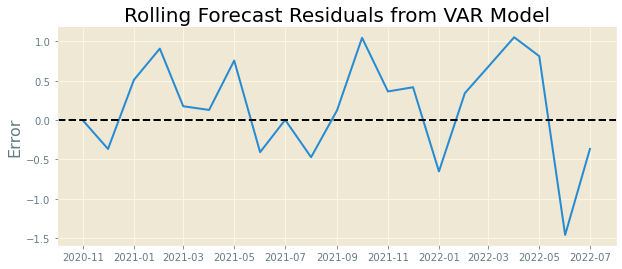

In [348]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from VAR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Percent MoM')

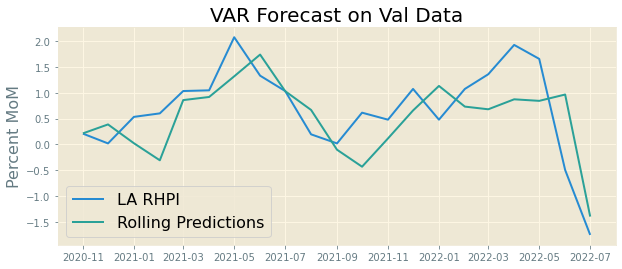

In [352]:
plt.figure(figsize=(10,4))

plt.plot(val_data['la_rhpi'])
plt.plot(rolling_predictions)

plt.legend(('LA RHPI', 'Rolling Predictions'), fontsize=16)

plt.title('VAR Forecast on Val Data', fontsize=20)
plt.ylabel('Percent MoM', fontsize=16)

## Forecast on Test Data

In [412]:
model = VAR(model_df)
model_fit = model.fit(maxlags=3)
last_observations = train_data.values[-3:]
pred = model_fit.forecast(last_observations, steps=3)
forecast = pred[:,-1]

In [413]:
forecast, lower_bounds, upper_bounds = model_fit.forecast_interval(last_observations, steps=3, alpha=0.05)


In [414]:
forecast = forecast[:,-1]
lower_bounds = lower_bounds[:,-1]
upper_bounds = upper_bounds[:,-1]

In [415]:
forecast = pd.Series(forecast, index=pd.date_range(start=model_df.index[-1] + relativedelta(months=1), periods=3, freq='M'))
upper_bounds = pd.Series(upper_bounds, index=pd.date_range(start=model_df.index[-1] + relativedelta(months=1), periods=3, freq='M'))
lower_bounds = pd.Series(lower_bounds, index=pd.date_range(start=model_df.index[-1] + relativedelta(months=1), periods=3, freq='M'))

In [416]:
forecast.index = forecast.index.to_period('M').to_timestamp('D')

In [417]:
forecast['2024-05-01'] = model_df.loc['2024-05-01','la_rhpi']

In [419]:
forecast.sort_index(inplace=True)

Text(0, 0.5, 'Percent MoM')

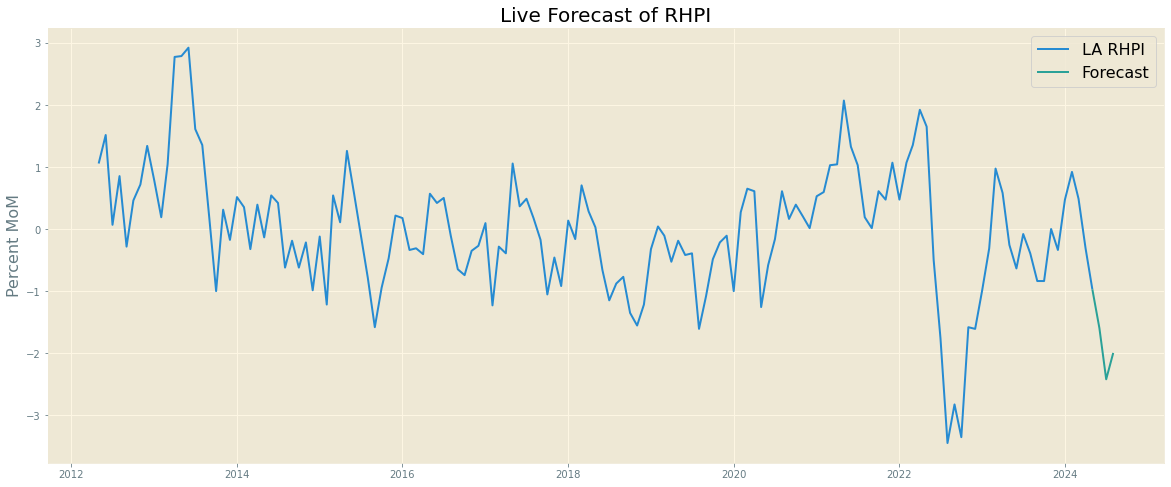

In [425]:
plt.figure(figsize=(20,8))

plt.plot(model_df['la_rhpi'])
plt.plot(forecast)

plt.legend(('LA RHPI', 'Forecast'), fontsize=16)

plt.title('Live Forecast of RHPI', fontsize=20)
plt.ylabel('Percent MoM', fontsize=16)